In [50]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import os
import calendar
from datetime import datetime, timedelta, date
import warnings
#import kaggle 
import zipfile

In [51]:
database_path = "datasets/football/european-football/database.sqlite" 
conn = sqlite3.connect(database_path)
tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
print(tables)

    type               name           tbl_name  rootpage  \
0  table    sqlite_sequence    sqlite_sequence         4   
1  table  Player_Attributes  Player_Attributes        11   
2  table             Player             Player        14   
3  table              Match              Match        18   
4  table             League             League        24   
5  table            Country            Country        26   
6  table               Team               Team        29   
7  table    Team_Attributes    Team_Attributes         2   

                                                 sql  
0             CREATE TABLE sqlite_sequence(name,seq)  
1  CREATE TABLE "Player_Attributes" (\n\t`id`\tIN...  
2  CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...  
3  CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...  
4  CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...  
5  CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...  
6  CREATE TABLE "Team" (\n\t`id`\tINTEGER PRIMARY...  
7  CREATE TABLE `Te

In [52]:
dataframes = {}
for idx, name in enumerate(tables['name']):
    if name.lower() != "sqlite_sequence":
        file = ((name.lower() + '_df'))
        if file != "_df":
            query = f"\
                    SELECT * \
                    FROM {name}\
                    "
            df = pd.read_sql(query, conn)
            exec(f'{file} = df.copy()')
            print(file, df.shape)
            df = df.drop_duplicates()
            dataframes[file]= df
print("Data imported")

player_attributes_df (183978, 42)
player_df (11060, 7)
match_df (25979, 115)
league_df (11, 3)
country_df (11, 2)
team_df (299, 5)
team_attributes_df (1458, 25)
Data imported


In [53]:
# Print pd.Dataframe.info() for each dataframe.
for key, df in dataframes.items():
    print(f"{key}:")
    print(f"{df.info()}\n\n")

player_attributes_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   183978 non-null  int64  
 1   player_fifa_api_id   183978 non-null  int64  
 2   player_api_id        183978 non-null  int64  
 3   date                 183978 non-null  object 
 4   overall_rating       183142 non-null  float64
 5   potential            183142 non-null  float64
 6   preferred_foot       183142 non-null  object 
 7   attacking_work_rate  180748 non-null  object 
 8   defensive_work_rate  183142 non-null  object 
 9   crossing             183142 non-null  float64
 10  finishing            183142 non-null  float64
 11  heading_accuracy     183142 non-null  float64
 12  short_passing        183142 non-null  float64
 13  volleys              181265 non-null  float64
 14  dribbling            183142 non-null  float64


In [87]:
# Set the directory path.
kaggle_dataset_path = 'davidcariboo/player-scores'
directory_path = 'datasets/football/player-scores'
# Download the datasets
#directory_path = os.path.expanduser('~/src/sorrentum1/research_llm/player-scores')
#os.makedirs(directory_path, exist_ok=True)
#kaggle.api.dataset_download_files(kaggle_dataset_path, path=directory_path, unzip=True)
# Manually unzip the files.
#for dirname, _, filenames in os.walk(local_directory):
#    for filename in filenames:
#        if filename.endswith('.zip'):
#            zip_path = os.path.join(dirname, filename)
#            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#                zip_ref.ref.extractall(local_directory)
# Load the datasets into pandas dataframes.            
dataframes_2={}
for dirname, _, filenames in os.walk(directory_path):
    for filename in filenames:
        if filename.endswith(".csv"):
            file=filename.split('.')
            file=((file[0]+"_df"))
            if file !="_df":
                filepath=os.path.join(dirname,filename)
                df=pd.read_csv(filepath,sep=",",encoding = "UTF-8")
                exec(f'{file} = df.copy()')
                print(file, df.shape)
                df = df.drop_duplicates()
                dataframes_2[file]= df
print('Data imported')

games_df (67964, 23)
appearances_df (1573079, 13)
competitions_df (43, 11)
clubs_df (426, 17)
players_df (30516, 23)
game_lineups_df (2191911, 10)
game_events_df (734047, 10)
player_valuations_df (467132, 5)
club_games_df (135928, 11)
Data imported


In [88]:
# Print pd.Dataframe.info() for each dataframe.
for key, df in dataframes_2.items():
    print(f"{key}:")
    print(f"{df.info()}\n\n")

games_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67964 entries, 0 to 67963
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   game_id                 67964 non-null  int64  
 1   competition_id          67964 non-null  object 
 2   season                  67964 non-null  int64  
 3   round                   67964 non-null  object 
 4   date                    67964 non-null  object 
 5   home_club_id            67964 non-null  int64  
 6   away_club_id            67964 non-null  int64  
 7   home_club_goals         67964 non-null  int64  
 8   away_club_goals         67964 non-null  int64  
 9   home_club_position      47914 non-null  float64
 10  away_club_position      47914 non-null  float64
 11  home_club_manager_name  67219 non-null  object 
 12  away_club_manager_name  67219 non-null  object 
 13  stadium                 67750 non-null  object 
 14  attendance              5828

In [89]:
# Function to calculate age.
def calculate_age(born, reference_date):
    return reference_date.year - born.year - ((reference_date.month, reference_date.day) < (born.month, born.day))
# Function to calculate days until contract expiration.
def days_until_expiration(expiration_date, reference_date):
    return (expiration_date - reference_date).dt.days
# Current time for reference in multiple calculations.
current_datetime = datetime.now()
# Process player's birthdates and ages.
players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])
players_df.dropna(subset=['date_of_birth'], inplace=True)  # More concise for dropping nulls
players_df['age'] = players_df['date_of_birth'].apply(calculate_age, args=(current_datetime,))
# Process contract expiration and days remaining.
players_df['contract_expiration_date'] = pd.to_datetime(players_df['contract_expiration_date'])
players_df.dropna(subset=['contract_expiration_date'], inplace=True)
players_df['term_days_remaining'] = days_until_expiration(players_df['contract_expiration_date'], current_datetime)
# Add position to player valuations.
position_df=players_df[['player_id', 'name', 'position', 'sub_position', 'term_days_remaining']]
player_valuations_df = player_valuations_df.merge(
    position_df,
    on='player_id',
    how='left'
)
# Add position to appearances.
value_df=players_df[['player_id','position','sub_position', 'market_value_in_eur', 'term_days_remaining']]
appearances_df1=value_df.merge(
    appearances_df, 
    left_on='player_id', 
    right_on='player_id')
# Add year to player valuations.
player_valuations_df['date']=pd.to_datetime(player_valuations_df['date'], format="%Y-%m-%d")
player_valuations_df['year']=player_valuations_df['date'].dt.year
# Add year to player appearances.
appearances_df['datetime']=pd.to_datetime(appearances_df['date'], format="%Y-%m-%d")
appearances_df['year']=appearances_df['datetime'].dt.year

/tmp/ipykernel_1169/2096099936.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_value_player_valuations_df = _valuations_df[player_valuations_df['market_value_in_eur'] > 40e6]


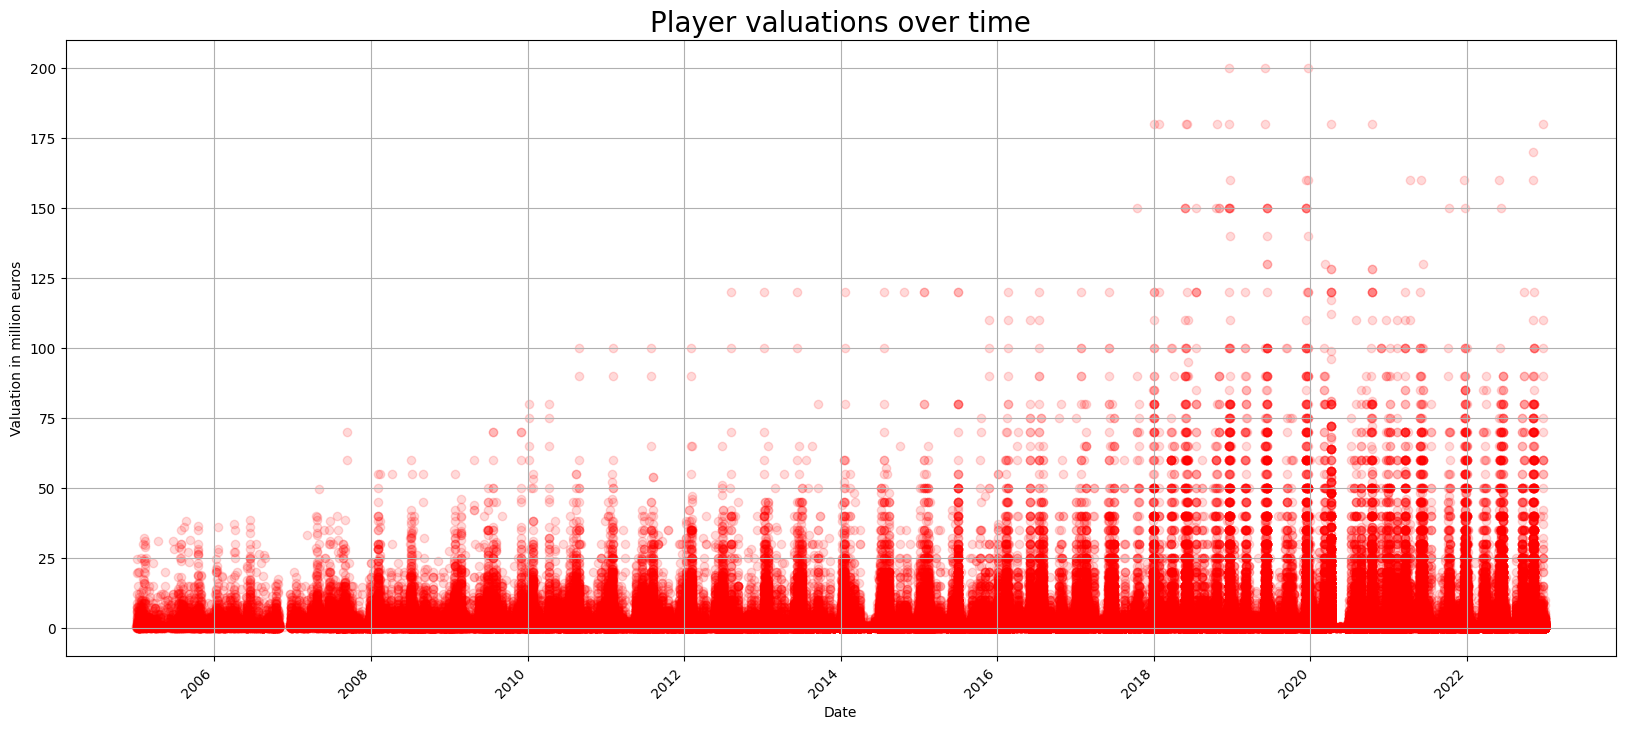

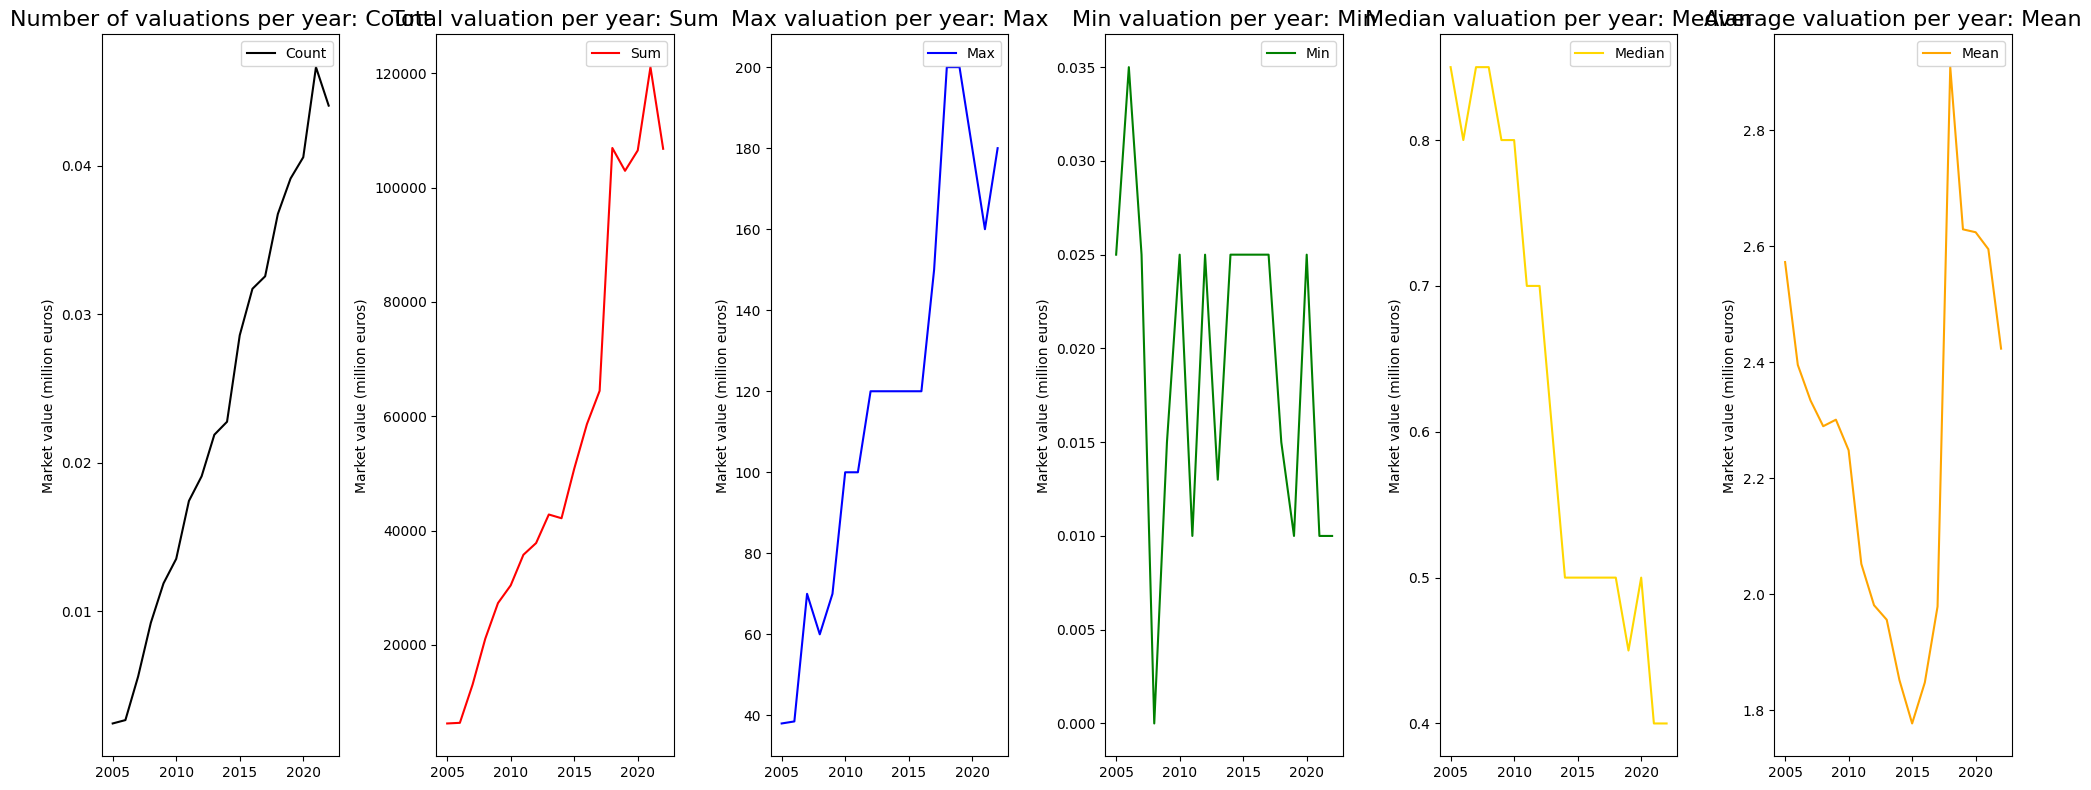

/tmp/ipykernel_1169/2096099936.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['date'].dt.year.unique(), rotation=90)
/tmp/ipykernel_1169/2096099936.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['date'].dt.year.unique(), rotation=90)
/tmp/ipykernel_1169/2096099936.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['date'].dt.year.unique(), rotation=90)
/tmp/ipykernel_1169/2096099936.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['date'].dt.year.unique(), rotation=90)
/tmp/ipykernel_1169/2096099936.py:47: UserWarning: set_ticklabels() 

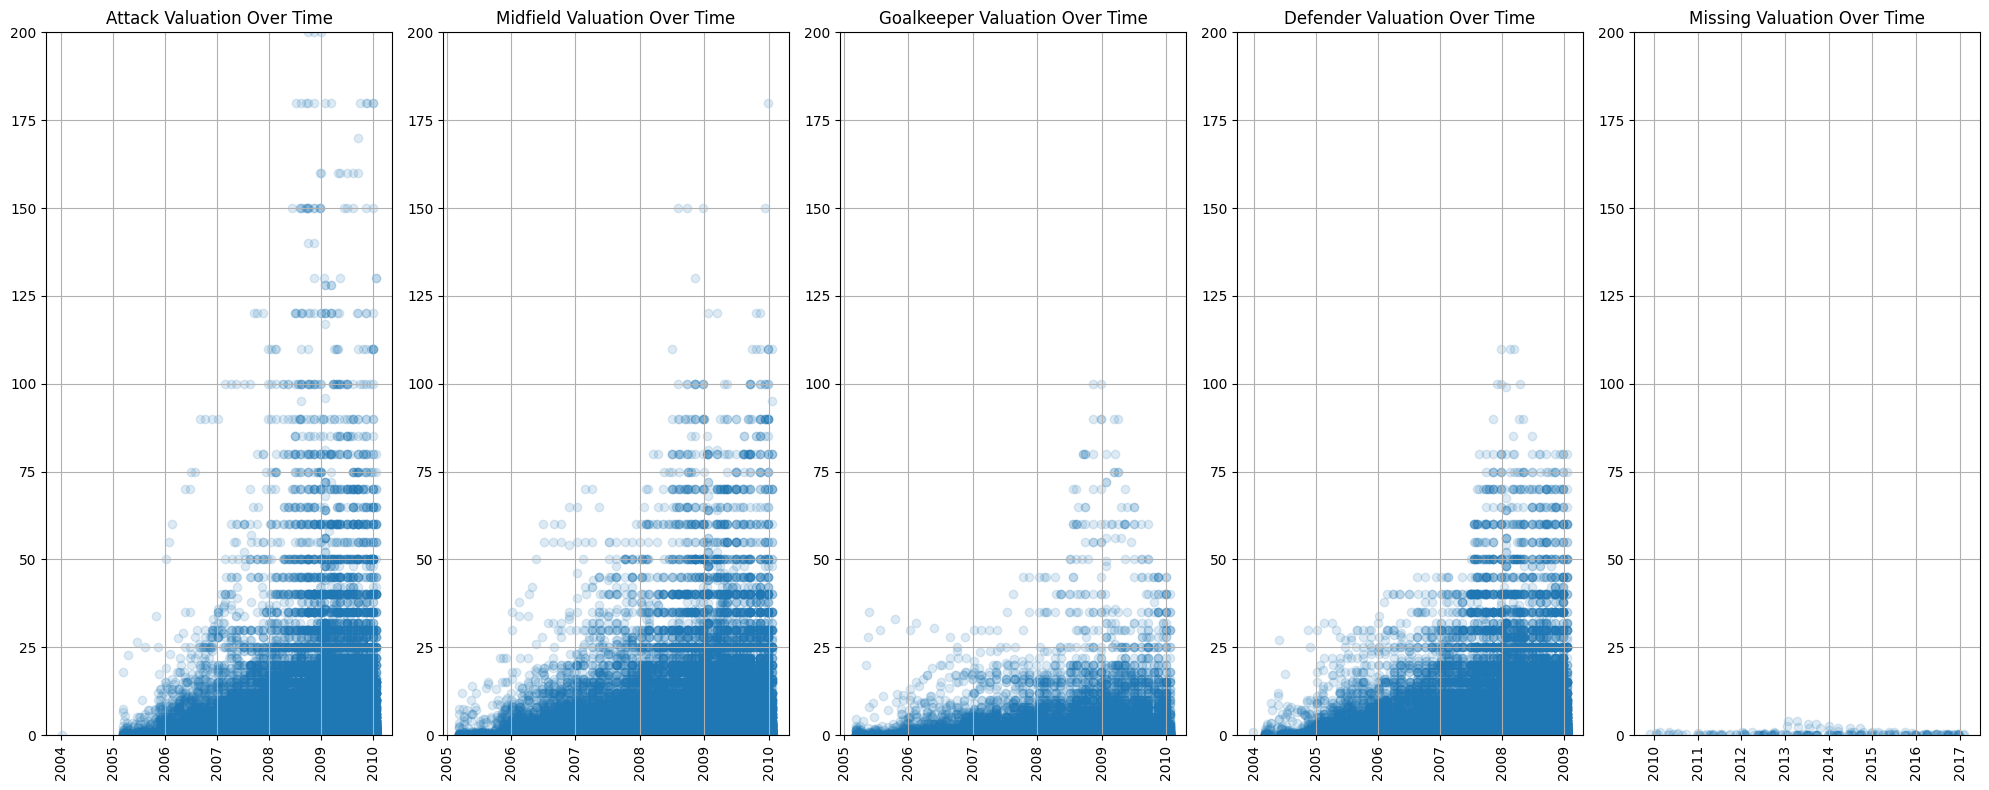

In [91]:
def plot_scatter(df, title, xlabel, ylabel, color, alpha=0.15):
    """Generalized scatter plot function."""
    plt.scatter(df['date'], df['market_value_in_eur']/1e6, c=color, alpha=alpha)
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)

def plot_time_series(df_groups, titles, ylabels, styles, colors):
    """Function to plot time series data from grouped DataFrames."""
    fig, axes = plt.subplots(1, len(df_groups), figsize=(20, 8))
    if len(df_groups) == 1:
        axes = [axes]  # Ensure axes is iterable for a single subplot
    for ax, (title, ylabel, df_group, style, color) in zip(axes, zip(titles, ylabels, df_groups, styles, colors)):
        ax.plot(df_group.index, df_group/1e6, style, color=color, label=title.split(':')[1].strip())
        ax.set_title(title, fontsize=16)
        ax.set_ylabel(ylabel)
        ax.legend()
    plt.tight_layout()
    plt.show()

# Load and preprocess data
players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])
players_df2 = players_df.dropna(subset=['date_of_birth'])
positions = players_df2['position'].unique()
# Filter and process valuation data
_valuations_df = player_valuations_df[(player_valuations_df['year'] > 2004) & (player_valuations_df['year'] < 2023)]
high_value_player_valuations_df = _valuations_df[player_valuations_df['market_value_in_eur'] > 40e6]
# Visualization 1: Scatter plot of player valuations over time
plt.figure(figsize=(20, 8))
plot_scatter(_valuations_df, 'Player valuations over time', 'Date', 'Valuation in million euros', 'red')
# Visualization 2: Different statistical metrics over time
groups = [_valuations_df.groupby('year')['market_value_in_eur'].agg(func) for func in ('count', 'sum', 'max', 'min', 'median', 'mean')]
titles = ['Number of valuations per year: Count', 'Total valuation per year: Sum', 'Max valuation per year: Max', 'Min valuation per year: Min', 'Median valuation per year: Median', 'Average valuation per year: Mean']
styles = ['-', '-', '-', '-', '-', '-']
colors = ['black', 'red', 'blue', 'green', 'gold', 'orange']
plot_time_series(groups, titles, ['Market value (million euros)'] * len(groups), styles, colors)
# Visualization by position
fig, axes = plt.subplots(1, len(positions), figsize=(20, 8))
for ax, position in zip(axes, positions):
    subset = player_valuations_df[player_valuations_df['position'] == position]
    if not subset.empty:
        ax.scatter(subset['date'], subset['market_value_in_eur']/1e6, alpha=0.15)
        ax.set_title(f"{position} Valuation Over Time", fontsize=12)
        ax.set_ylim(0, 200)
        ax.set_xticklabels(subset['date'].dt.year.unique(), rotation=90)
        ax.grid(True)
plt.tight_layout()
plt.show()

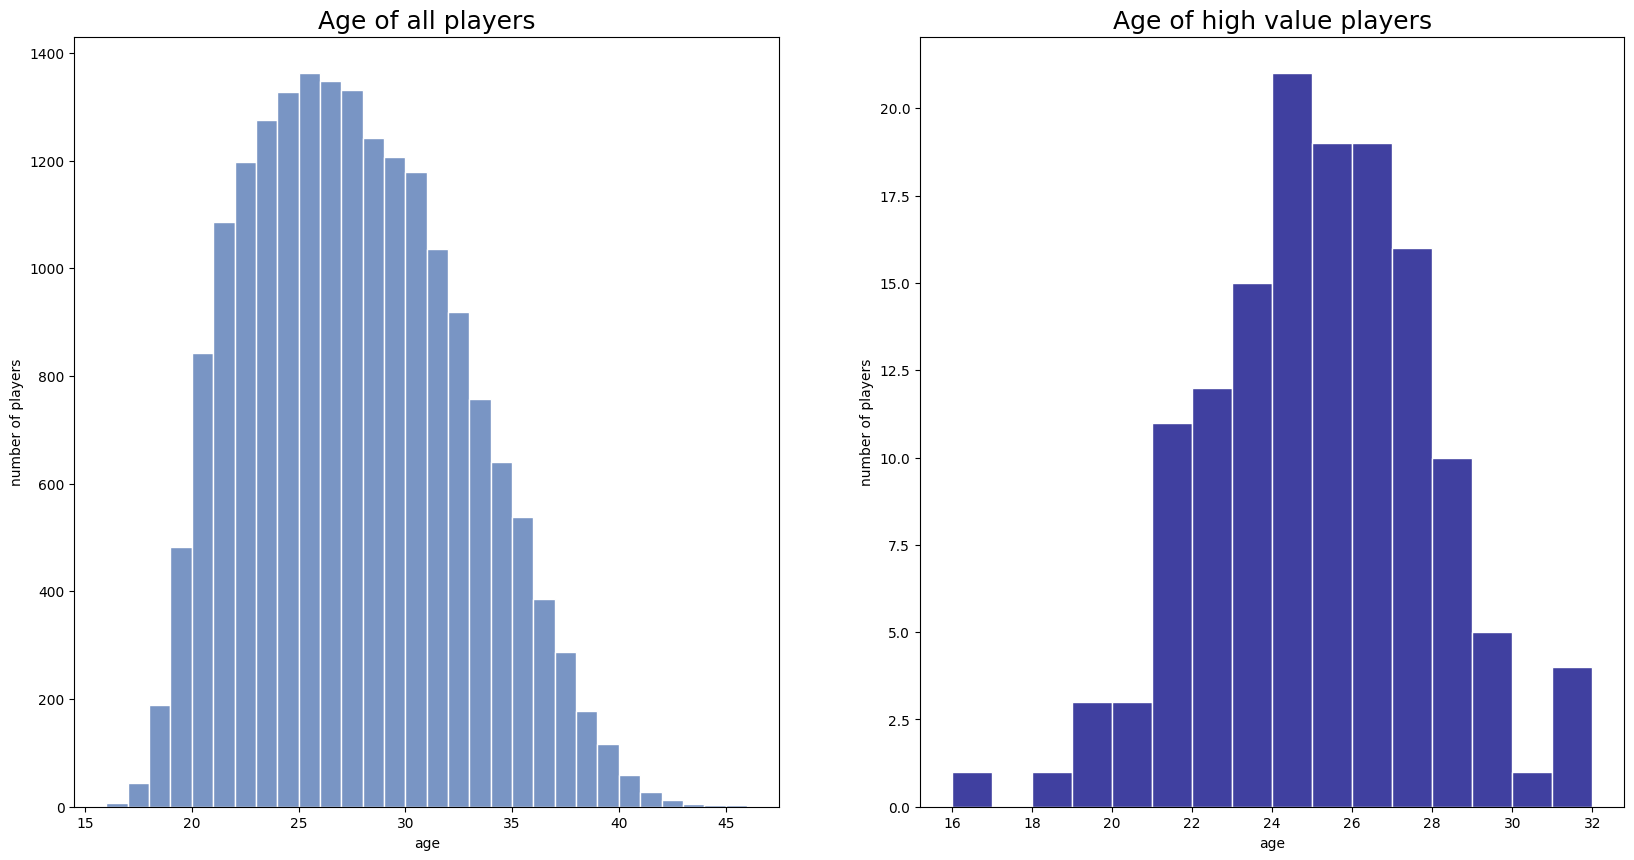

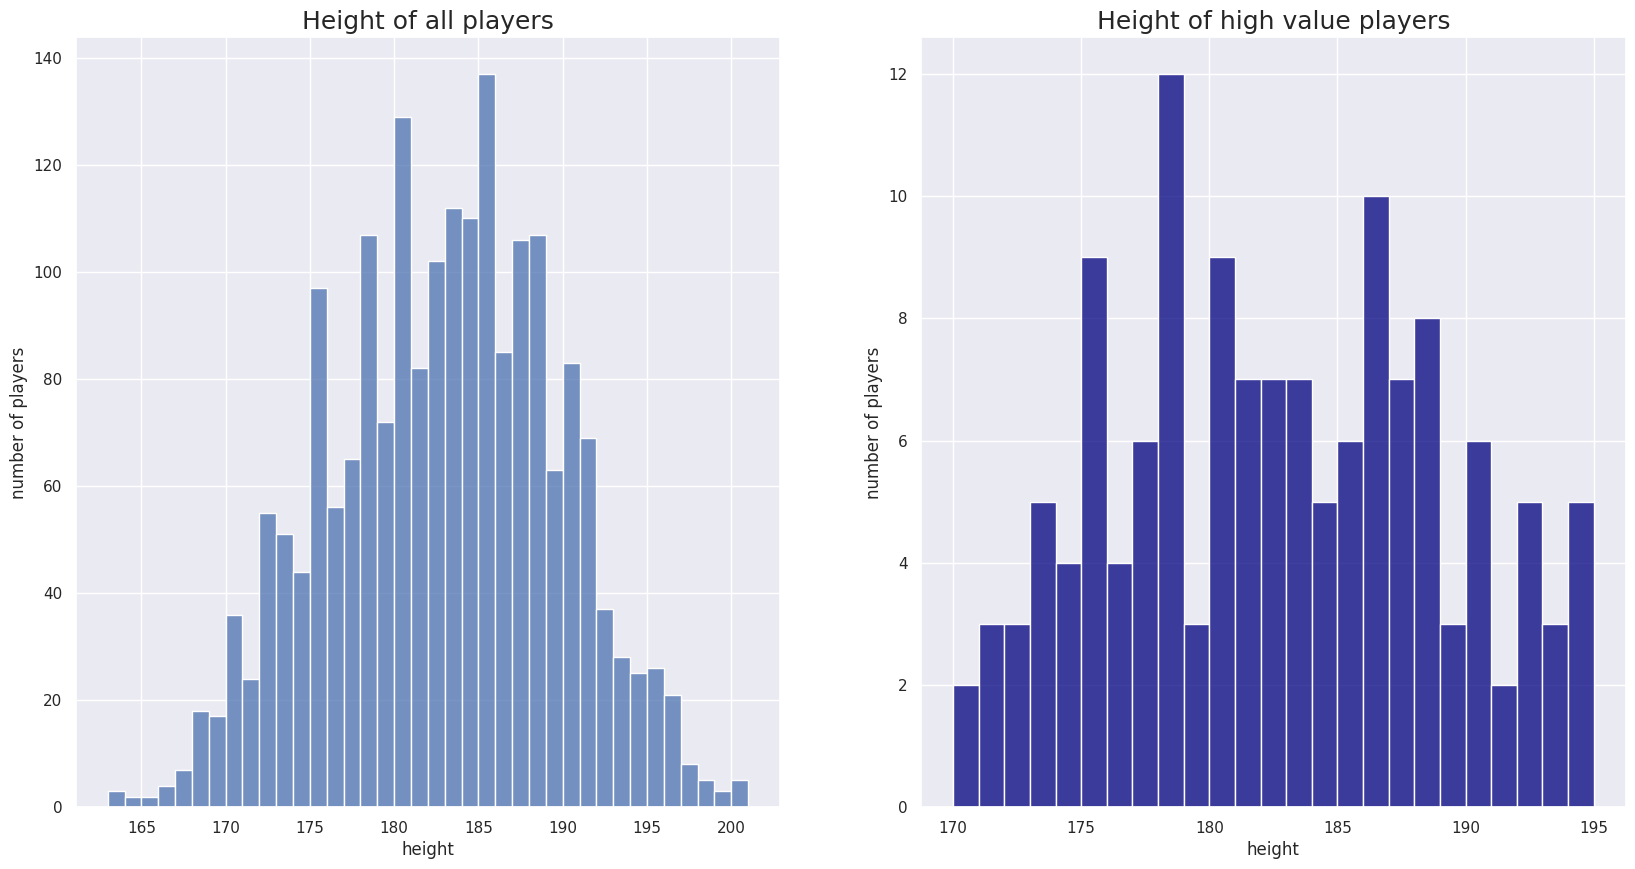

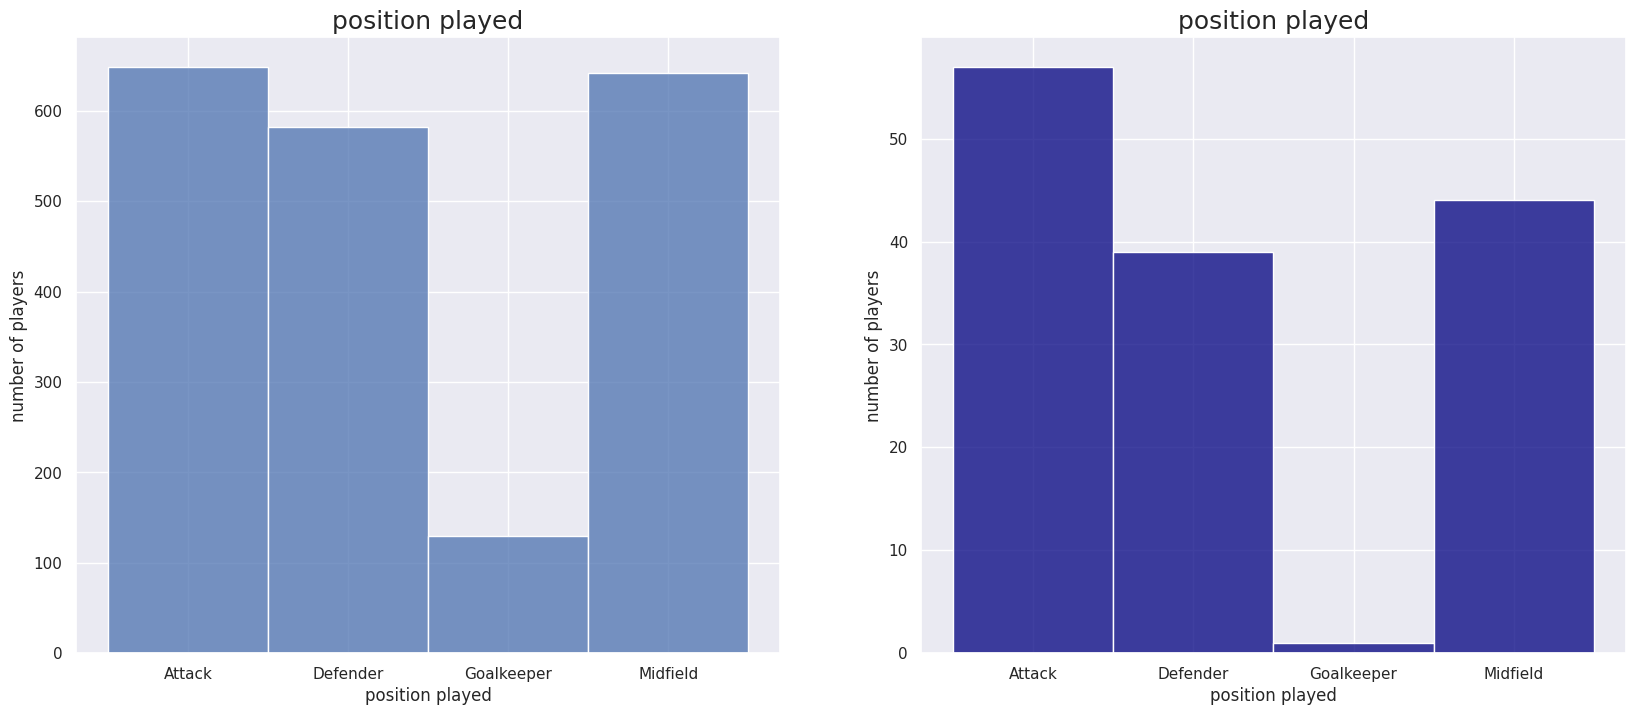

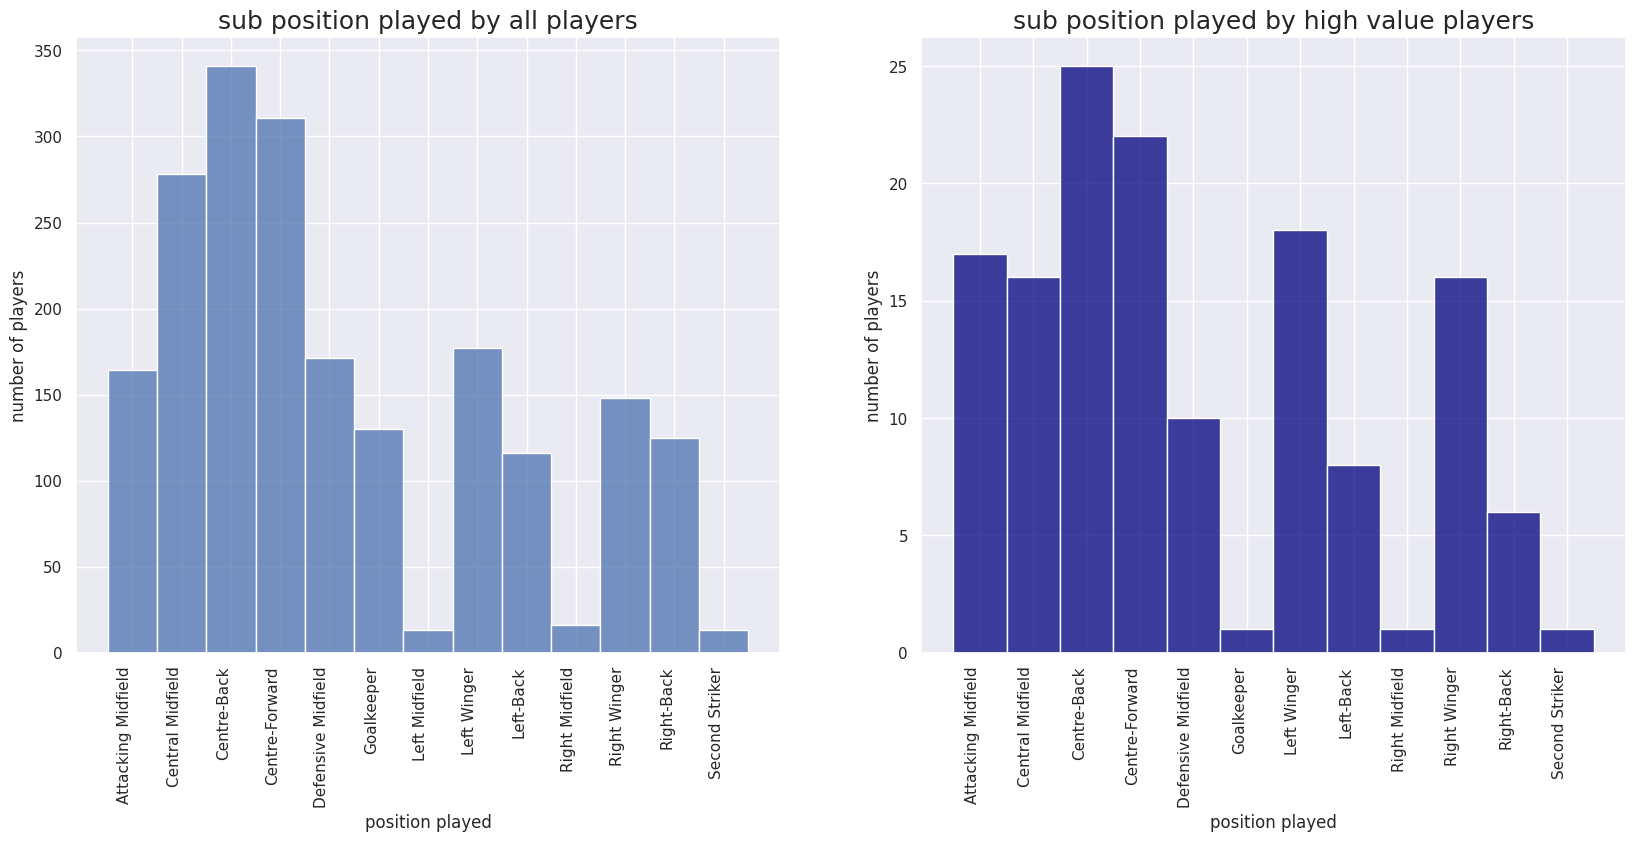

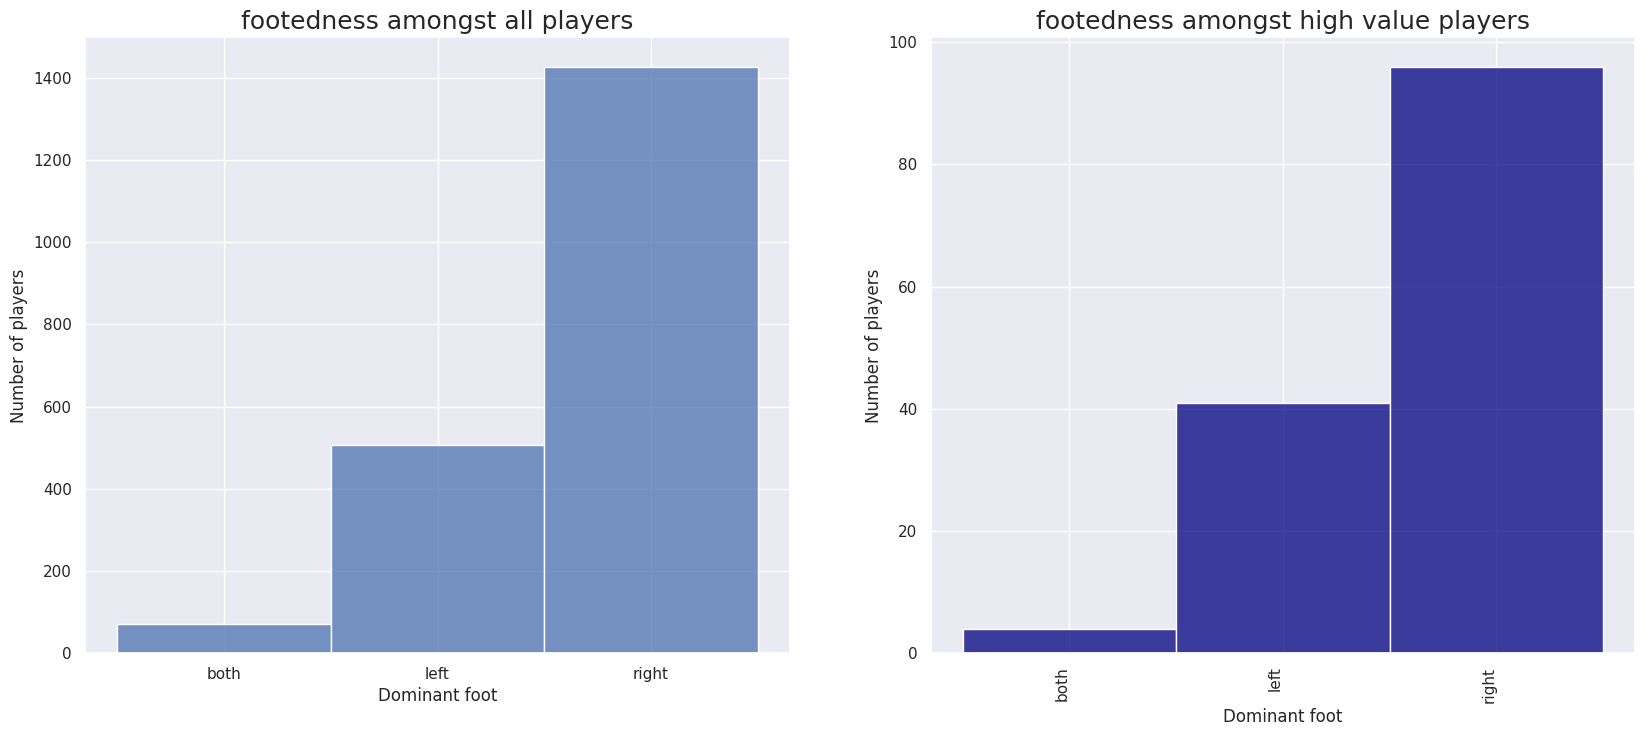

In [92]:
#overview of player dataset
#remove players with no Market Value
players_df1 = players_df[players_df.highest_market_value_in_eur.isnull() == False]
#order by Market Value
players_df1 = players_df1.sort_values("highest_market_value_in_eur", ascending = False)
#filter by season and value
players_df1 = players_df[players_df['last_season'] >= 2021]
players_df1 = players_df1[players_df1['highest_market_value_in_eur'] >= 10000000]
high_value_players_df = players_df1[(players_df1.market_value_in_eur > 40000000 )]
positions=players_df.position.unique()
# Show player age distribution
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
sns.set(rc={'figure.figsize':(20,10)})
sns.histplot(x='age',data=players_df, binwidth=1,color='b')
plt.title("Age of all players",fontsize=18)
plt.xlabel('age'); plt.ylabel('number of players')
plt.subplot(1, 2, 2)
sns.histplot(x='age',data=high_value_players_df, binwidth=1,color='navy')
plt.title("Age of high value players",fontsize=18)
plt.xlabel('age'); plt.ylabel('number of players')
# Show player height distribution
players_df3 = players_df1[players_df1.height_in_cm.isnull() == False]
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
sns.set(rc={'figure.figsize':(20,10)})
sns.histplot(x='height_in_cm',data=players_df3, binwidth=1,color='b')
plt.title("Height of all players",fontsize=18)
plt.xlabel('height'); plt.ylabel('number of players')
plt.subplot(1, 2, 2)
sns.histplot(x='height_in_cm',data=high_value_players_df, binwidth=1,color='navy')
plt.title("Height of high value players",fontsize=18)
plt.xlabel('height'); plt.ylabel('number of players')
# Show position data
players_df1 = players_df1.sort_values("position", ascending = True)
high_value_players_df1 = high_value_players_df.sort_values("position", ascending = True)
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
plt.title("position played",fontsize=18);plt.grid(True)
sns.histplot(x='position',data=players_df1, binwidth=1,color='b')
plt.xlabel('position played'); plt.ylabel('number of players')
plt.subplot(1, 2, 2)
sns.histplot(x='position',data=high_value_players_df1, binwidth=1,color='navy')
plt.title("position played",fontsize=18);plt.grid(True)
plt.xlabel('position played'); plt.ylabel('number of players')
# Show subposition data
players_df1 = players_df1.sort_values("sub_position", ascending = True)
high_value_players_df1 = high_value_players_df.sort_values("sub_position", ascending = True)
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
sns.histplot(x='sub_position',data=players_df1, binwidth=1,color='b')
plt.title("sub position played by all players",fontsize=18);plt.grid(True)
plt.xlabel('position played'); plt.ylabel('number of players')
plt.xticks(rotation=90, ha='right');
plt.subplot(1, 2, 2)
sns.histplot(x='sub_position',data=high_value_players_df1, binwidth=1,color='navy')
plt.title("sub position played by high value players",fontsize=18);plt.grid(True)
plt.xlabel('position played'); plt.ylabel('number of players')
plt.xticks(rotation=90, ha='right');
# Show  footedness data
players_df1 = players_df1.sort_values("foot", ascending = True)
high_value_players_df1 = high_value_players_df1.sort_values("foot", ascending = True)
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
sns.histplot(x='foot',data=players_df1, binwidth=1,color='b')
plt.title("footedness amongst all players",fontsize=18);plt.grid(True)
plt.xlabel('Dominant foot'); plt.ylabel('Number of players')
plt.subplot(1, 2, 2)
sns.histplot(x='foot',data=high_value_players_df1, binwidth=1,color='navy')
plt.title("footedness amongst high value players",fontsize=18);plt.grid(True)
plt.xlabel('Dominant foot'); plt.ylabel('Number of players')
plt.xticks(rotation=90, ha='right');

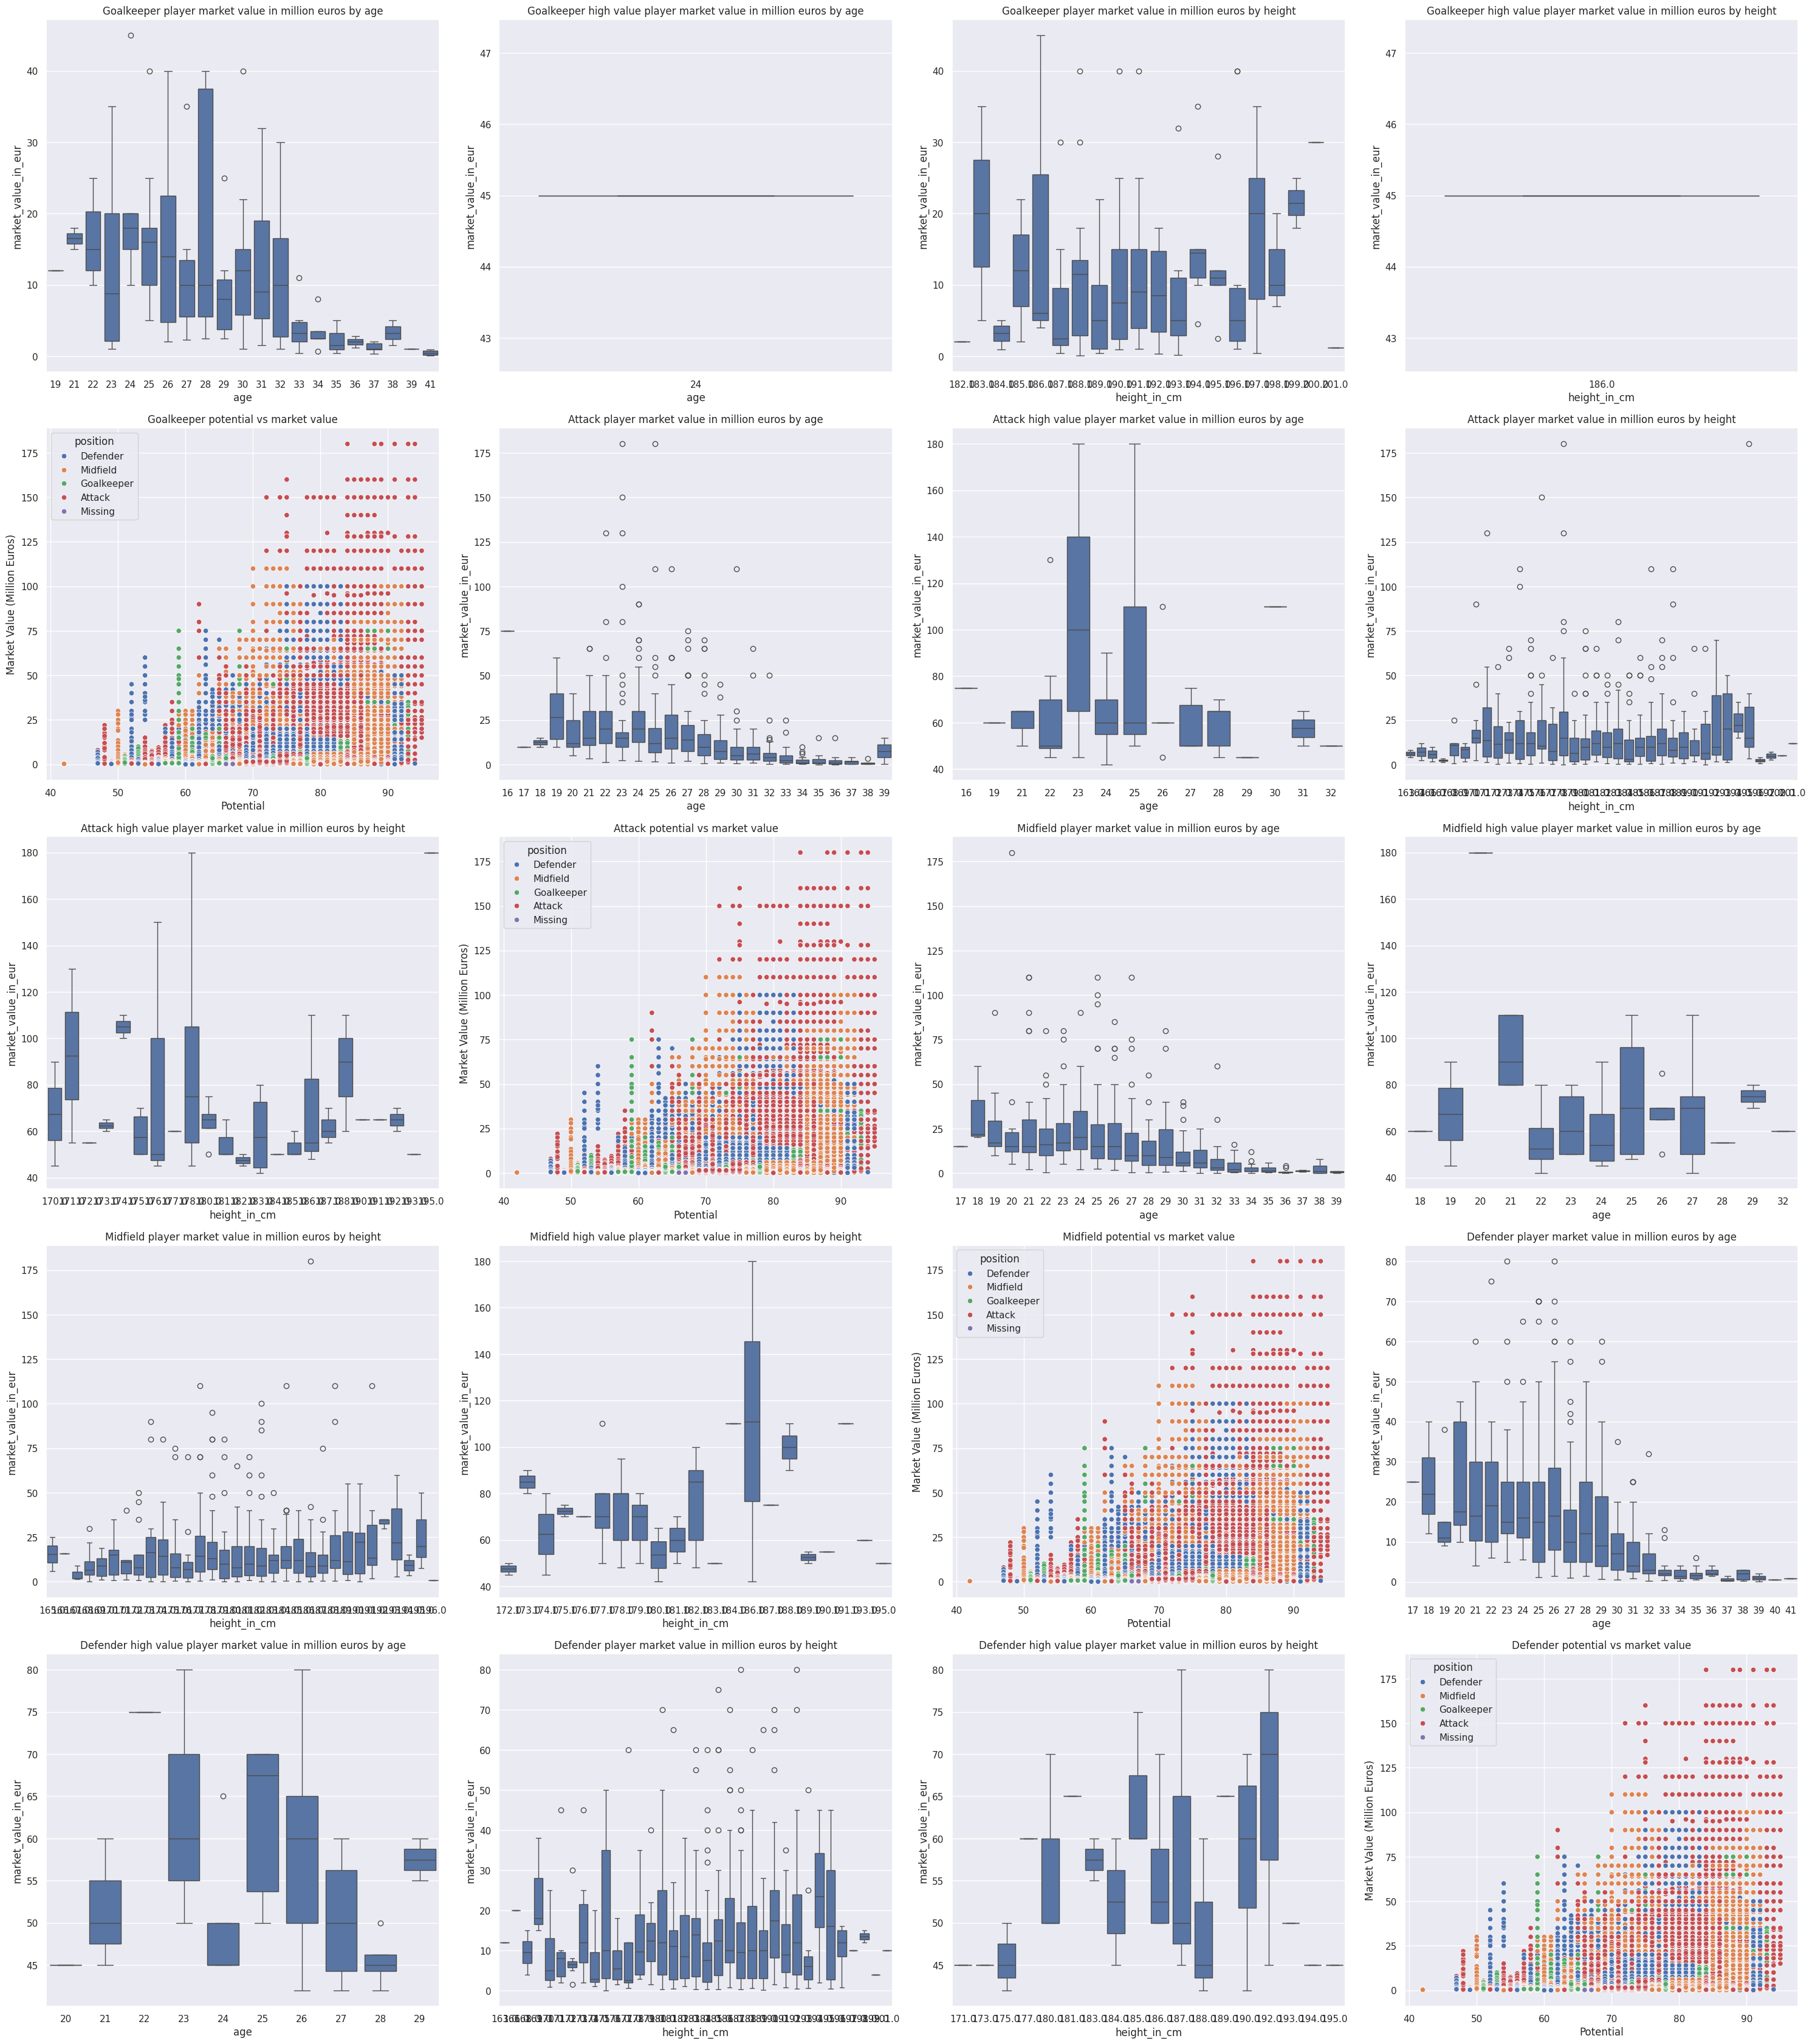

In [108]:
positions = players_df1['position'].unique()
# Set up the figure
f = plt.figure(figsize=(30, 40))  # Adjust size as needed to fit all plots
# Indices for subplots
n = 1
# Plot for each position
for position in positions:
    # Market value by age for all players
    plt.subplot(6, 4, n)  # 6 rows, 4 columns, subplot n
    players_df2 = players_df1[players_df1['position'] == position]
    sns.boxplot(x=players_df2["age"], y=(players_df2['market_value_in_eur'])/1000000)
    plt.title(f'{position} player market value in million euros by age')
    n += 1
    # Market value by age for high-value players
    plt.subplot(6, 4, n)
    high_value_players_df2 = high_value_players_df[high_value_players_df['position'] == position]
    sns.boxplot(x=high_value_players_df2["age"], y=(high_value_players_df2['market_value_in_eur'])/1000000)
    plt.title(f'{position} high value player market value in million euros by age')
    n += 1
    # Market value by height for all players
    plt.subplot(6, 4, n)
    sns.boxplot(x=players_df2["height_in_cm"], y=(players_df2['market_value_in_eur'])/1000000)
    plt.title(f'{position} player market value in million euros by height')
    n += 1
    # Market value by height for high-value players
    plt.subplot(6, 4, n)
    sns.boxplot(x=high_value_players_df2["height_in_cm"], y=(high_value_players_df2['market_value_in_eur'])/1000000)
    plt.title(f'{position} high value player market value in million euros by height')
    n += 1
    # Additional plot comparing 'potential' and 'market_value_in_eur'
    plt.subplot(6, 4, n)
    sns.scatterplot(x=player_attributes_df['potential'], y=(player_attributes_df['market_value_in_eur'])/1000000, hue=player_attributes_df['position'])
    plt.title(f'{position} potential vs market value')
    plt.ylabel('Market Value (Million Euros)')
    plt.xlabel('Potential')
    n += 1
# Adjust layout
plt.tight_layout()
plt.show()